## The Problem: Large Movie Dataset Review
### Classify movie reviews from IMDB into positive or negative sentiment.
### Download the dataset [here](https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz)

In [44]:
# imports

from gensim.models import KeyedVectors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import text_dataset_from_directory
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Dense, Input, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import utils

## Exploring the data

In [45]:
# Importing & preprocessing the dataset

train_ds = text_dataset_from_directory('aclImdb/aclImdb/train')
test_ds  = text_dataset_from_directory('aclImdb/aclImdb/test')

dfTrain = pd.DataFrame(train_ds.unbatch().as_numpy_iterator(), columns=['text', 'label'])
dfTest  = pd.DataFrame(test_ds.unbatch().as_numpy_iterator(), columns=['text', 'label'])
_, xts = train_test_split(dfTest, stratify=dfTest['label'], test_size=0.25)

dfTrain['text'] = dfTrain['text'].map(lambda x: x.decode())
xts['text'] = xts['text'].map(lambda x: x.decode())

Found 25000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [62]:
pd.options.display.max_colwidth = 200
dfTrain.sample(n=5)

,text,label
2460,"When I heard about ""Hammerhead"" being released on DVD and finally found it at my local DVD store, I thought ""well, just another cheap monster movie from Nu Image"". Those guys around Boaz Davidson ...",1
24663,"I'm not usually given to hyperbole, but after seeing over two decades worth of Academy Awards, I can honestly say that this year's awards show was the most disgraceful example of poor direction, t...",0
10611,"This was a movie about infidelity and revenge. A twin with the ""twin"" connection senses that something is wrong with her sister. This movie took forever to establish the plot. A plot that has been...",0
15006,Cradle of Fear<br /><br />This isn't a movie where intricate delicate little narrative nuances occupy our attention. This is not a film where the special effects are supposed to leave us slack-jac...,0
6253,The Sentinel features a sort of run of the mill and clichéd suspense/mystery but is lifted with some good acting and taut pacing. These stories have already for the most part gone through as many ...,1


In [64]:
print(dfTrain.loc[0, 'text'])

Roommates Sugar and Bobby Lee are abducted by menacing dudes while out shopping one day and taken back to a secluded island that the girls reluctantly tell the thugs that they last visited when they were ten years of age and that a fortune is located on. All that just pretty much bookends a movie that is pretty much one long flashback about the girls first visit to the island and subsequent fight with a cannibalistic family.<br /><br />This one is extremely horribly acted by everyone involved to the point that I started feeling bad for poor Hank Worden who truly deserved much MUCH better. As much as I didn't like "Barracuda" (that's on the same DVD) I have to admit that this film makes that one look like Citizen Kane.<br /><br />Eye Candy: one pair of tits (they might belong to Kirsten Baker) <br /><br />My Grade: F <br /><br />Dark Sky DVD Extras: Vintage ads for various drive-in food; and Trailers for "Bonnie's Kids" (features nudity), "the Centerfold Girls", "Part-time Wife" (featur

## Tokenize the text

In [66]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dfTrain['text'].tolist())
train_sequences = tokenizer.texts_to_sequences(dfTrain['text'].tolist())
test_sequences = tokenizer.texts_to_sequences(xts['text'].tolist())


word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 88582 unique tokens.


In [68]:
print(train_sequences[0])

[9092, 5283, 2, 3462, 844, 23, 10086, 31, 3537, 12258, 134, 43, 5745, 28, 248, 2, 620, 142, 5, 3, 9878, 1105, 12, 1, 536, 7693, 373, 1, 3950, 12, 33, 233, 5340, 51, 33, 68, 744, 150, 4, 555, 2, 12, 3, 3196, 6, 6108, 20, 29, 12, 40, 181, 73, 27631, 3, 17, 12, 6, 181, 73, 28, 193, 2753, 41, 1, 536, 83, 1975, 5, 1, 1105, 2, 3657, 545, 16, 3, 12259, 220, 7, 7, 11, 28, 6, 573, 2353, 914, 31, 313, 571, 5, 1, 210, 12, 10, 642, 544, 75, 15, 335, 4381, 40830, 34, 368, 1810, 73, 73, 125, 14, 73, 14, 10, 158, 37, 34701, 195, 20, 1, 169, 285, 10, 25, 5, 971, 12, 11, 19, 163, 12, 28, 165, 37, 3840, 3538, 7, 7, 741, 1906, 28, 2154, 4, 7799, 33, 235, 4844, 5, 7694, 3366, 7, 7, 58, 1239, 1203, 7, 7, 462, 1740, 285, 2253, 6538, 8288, 15, 995, 1275, 8, 1640, 2, 4201, 15, 34702, 359, 941, 1003, 1, 27632, 536, 170, 55, 319, 941, 1003, 4845, 452, 4676, 1236, 1, 285, 79, 263, 16, 34703, 34701]


In [71]:
print([tokenizer.index_word[k] for k in train_sequences[0]])

['roommates', 'sugar', 'and', 'bobby', 'lee', 'are', 'abducted', 'by', 'menacing', 'dudes', 'while', 'out', 'shopping', 'one', 'day', 'and', 'taken', 'back', 'to', 'a', 'secluded', 'island', 'that', 'the', 'girls', 'reluctantly', 'tell', 'the', 'thugs', 'that', 'they', 'last', 'visited', 'when', 'they', 'were', 'ten', 'years', 'of', 'age', 'and', 'that', 'a', 'fortune', 'is', 'located', 'on', 'all', 'that', 'just', 'pretty', 'much', 'bookends', 'a', 'movie', 'that', 'is', 'pretty', 'much', 'one', 'long', 'flashback', 'about', 'the', 'girls', 'first', 'visit', 'to', 'the', 'island', 'and', 'subsequent', 'fight', 'with', 'a', 'cannibalistic', 'family', 'br', 'br', 'this', 'one', 'is', 'extremely', 'horribly', 'acted', 'by', 'everyone', 'involved', 'to', 'the', 'point', 'that', 'i', 'started', 'feeling', 'bad', 'for', 'poor', 'hank', 'worden', 'who', 'truly', 'deserved', 'much', 'much', 'better', 'as', 'much', 'as', 'i', "didn't", 'like', 'barracuda', "that's", 'on', 'the', 'same', 'dvd',

In [74]:
MAX_SEQUENCE_LENGTH = max([max(map(len, train_sequences)), max(map(len, test_sequences))])

In [76]:
MAX_SEQUENCE_LENGTH

2493

In [78]:
train_data = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [81]:
print([tokenizer.index_word.get(k, '<PAD>') for k in train_data[0]])

['<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', 

# Train a classifier with Word Embeddings

In [83]:
countries_wiki = KeyedVectors.load('wiki-countries.w2v')

In [87]:
embedding_layer = utils.make_embedding_layer(countries_wiki, tokenizer, MAX_SEQUENCE_LENGTH)
countries_wiki_model = Sequential([
    Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'),
    embedding_layer,
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
countries_wiki_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [88]:
countries_wiki_history = countries_wiki_model.fit(
    train_data, dfTrain['label'].values,
    validation_data=(test_data, xts['label'].values),
    batch_size=64, epochs=30
)

Epoch 1/30


391/391 [==============================] - 7s 17ms/step - loss: 0.6196 - accuracy: 0.6639 - val_loss: 0.5827 - val_accuracy: 0.7072
Epoch 2/30
391/391 [==============================] - 6s 14ms/step - loss: 0.5636 - accuracy: 0.7170 - val_loss: 0.5712 - val_accuracy: 0.6984
Epoch 3/30
391/391 [==============================] - 6s 15ms/step - loss: 0.5415 - accuracy: 0.7271 - val_loss: 0.5472 - val_accuracy: 0.7280
Epoch 4/30
391/391 [==============================] - 6s 15ms/step - loss: 0.5294 - accuracy: 0.7358 - val_loss: 0.5789 - val_accuracy: 0.7078
Epoch 5/30
391/391 [==============================] - 6s 15ms/step - loss: 0.5260 - accuracy: 0.7379 - val_loss: 0.5419 - val_accuracy: 0.7229
Epoch 6/30
391/391 [==============================] - 6s 15ms/step - loss: 0.5172 - accuracy: 0.7431 - val_loss: 0.5354 - val_accuracy: 0.7304
Epoch 7/30
391/391 [==============================] - 6s 15ms/step - loss: 0.5175 - accuracy: 0.7408 - val_loss: 0.5307 - val_accuracy: 0.73

# Train with a different set of word embeddings

## GloVe: Global Vectors for Word Representation
### Download [here](http://nlp.stanford.edu/data/glove.6B.zip)

In [91]:
glove_wiki = KeyedVectors.load_word2vec_format('glove.6B/glove.6B.300d.txt', binary=False, no_header=True)

In [93]:
embedding_layer = utils.make_embedding_layer(glove_wiki, tokenizer, MAX_SEQUENCE_LENGTH)

glove_model = Sequential([
    Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'),
    embedding_layer,
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
glove_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [94]:
glove_history = glove_model.fit(
    train_data, dfTrain['label'].values,
    validation_data=(test_data, xts['label'].values),
    batch_size=32, epochs=30
)

Epoch 1/30
782/782 [==============================] - 14s 17ms/step - loss: 0.5524 - accuracy: 0.7266 - val_loss: 0.4707 - val_accuracy: 0.7922
Epoch 2/30
782/782 [==============================] - 13s 17ms/step - loss: 0.4367 - accuracy: 0.8123 - val_loss: 0.4254 - val_accuracy: 0.8086
Epoch 3/30
782/782 [==============================] - 13s 17ms/step - loss: 0.4106 - accuracy: 0.8232 - val_loss: 0.4024 - val_accuracy: 0.8250
Epoch 4/30
782/782 [==============================] - 14s 18ms/step - loss: 0.3962 - accuracy: 0.8260 - val_loss: 0.3891 - val_accuracy: 0.8280
Epoch 5/30
782/782 [==============================] - 16s 21ms/step - loss: 0.3871 - accuracy: 0.8292 - val_loss: 0.3783 - val_accuracy: 0.8293
Epoch 6/30
782/782 [==============================] - 26s 34ms/step - loss: 0.3829 - accuracy: 0.8312 - val_loss: 0.3885 - val_accuracy: 0.8248
Epoch 7/30
782/782 [==============================] - 22s 28ms/step - loss: 0.3798 - accuracy: 0.8314 - val_loss: 0.3801 - val_accuracy:

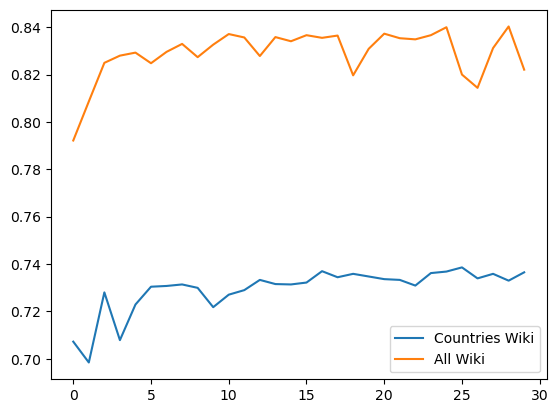

In [96]:
plt.plot(countries_wiki_history.history['val_accuracy'], label='Countries Wiki')
plt.plot(glove_history.history['val_accuracy'], label='All Wiki')
plt.legend()